<a href="https://colab.research.google.com/github/wo7864/Calligrapick/blob/master/tensorflow_cvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iter: 0
Loss: 1.306e+03

[[0.14375252 0.90757157 0.17954183 ... 0.21014089 0.83446691 0.42790943]
 [0.80638208 0.27074534 0.09553206 ... 0.51408566 0.58523799 0.48189423]
 [0.65937199 0.47455355 0.03971862 ... 0.76823314 0.16290344 0.61781413]
 ...
 [0.28051967 0.9246968  0.57115478 ... 0.57270797 0.23298553 0.94232296]
 [0.70119818 0.82953618 0.50885954 ... 0.65827413 0.2440193  0.71981286]
 [0.37831905 0.63043555 0.42875735 ... 0.04722662 0.87529497 0.00447568]]
[0.14375252 0.90757157 0.17954183 0.64920411 0.37364653 0.43918443
 0.67006027 0.69135352 0.29521706 0.32450396 0.48594541 0.36670856
 0.55549133 0.88699737 0.34162401 0.78617815 0.83080638 0.90000804
 0.42785742 0.76336465 0.17657132 0.58339862 0.39908043 0.51454877
 0.86986819 0.55090595 0.34441654 0.5230889  0.12601861 0.57567657
 0.24907973 0.34149809 0.01653208 0.4579978  0.10077851 0.60979974
 0.17390084 0.83152681 0.34538023 0.51946695 0.92752058 0.66807207
 0.60664083 0.63864421 0.16788555 0.22760204 0.6991289  0.7927

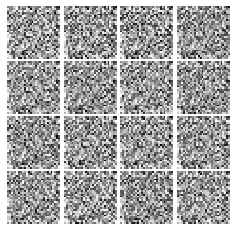

Iter: 10000
Loss: 92.24

[[0.30388042 0.15025709 0.47058347 ... 0.03740417 0.94382802 0.42177109]
 [0.51020638 0.46033433 0.43241549 ... 0.17560831 0.642356   0.83951249]
 [0.27124997 0.91881303 0.55826173 ... 0.06798987 0.77589009 0.81875177]
 ...
 [0.71102232 0.03888811 0.11438621 ... 0.30514276 0.24560893 0.38100631]
 [0.00610633 0.00925059 0.91077945 ... 0.74462572 0.1286783  0.45645116]
 [0.70158409 0.35525545 0.04828768 ... 0.92475344 0.41223145 0.92305954]]
[0.30388042 0.15025709 0.47058347 0.11240279 0.2798904  0.35455086
 0.60792492 0.70784142 0.26727685 0.049875   0.22487527 0.08869444
 0.21276723 0.19822453 0.20429037 0.43255184 0.25841377 0.01567148
 0.51226897 0.46622792 0.06248308 0.39635298 0.17747491 0.80439524
 0.18412558 0.00882408 0.35450447 0.84483462 0.69522005 0.76622823
 0.01834004 0.76109118 0.49143511 0.17188622 0.14025811 0.13017137
 0.15850715 0.17910902 0.551505   0.53084081 0.36830128 0.72959014
 0.25359706 0.97245276 0.27310664 0.76150054 0.40848587 0.7325

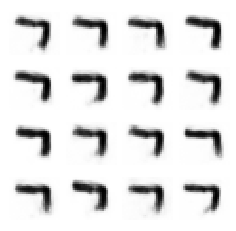

KeyboardInterrupt: ignored

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import cv2


dst = []
imgfile = []

for i in range(100):
  filename = 'gdrive/My Drive/data/img/1/{}.png'.format(i+1)
  tmp = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
  tmp = tmp.reshape(784,)
  tmp = tmp/255
  tmp = np.array(tmp)
  dst.append(tmp)
dst = np.array(dst)
dst = dst.reshape(100,784)

mb_size = 100
z_dim = 100
X_dim = dst.shape[1]
y_dim = 1
h_dim = 128
c = 0
lr = 1e-3

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


# =============================== Q(z|X) ======================================

X = tf.placeholder(tf.float32, shape=[None, X_dim])
c = tf.placeholder(tf.float32, shape=[None, y_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

Q_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, c):
    inputs = tf.concat(axis=1, values=[X, c])
    h = tf.nn.relu(tf.matmul(inputs, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


# =============================== P(X|z) ======================================

P_W1 = tf.Variable(xavier_init([z_dim + y_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    h = tf.nn.relu(tf.matmul(inputs, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits


# =============================== TRAINING ====================================
saver = tf.train.Saver()
z_mu, z_logvar = Q(X, c)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample, c)

# Sampling from random z
X_samples, _ = P(z, c)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer(lr).minimize(vae_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(60000):
    X_mb =dst
    y_mb = np.zeros(100).reshape(100,1)

    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb, c: y_mb})

    if it % 10000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()
        
        y = np.zeros(shape=[16, y_dim])
        y[:, np.random.randint(0, y_dim)] = 1.
        rand_z = np.random.rand(16, z_dim)
        print(rand_z)
        for i in range(16):
          print(rand_z[i])
        samples = sess.run(X_samples,
                           feed_dict={z: rand_z, c: y})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        plt.show()
        i += 1
        plt.close(fig)
        if it == 50000:
          saver.save(sess, "gdrive/My Drive/model/ga.ckpt")
        
 

In [0]:
from google.colab import files

uploaded = files.upload()

In [15]:
%cd content

/content


In [0]:
from google.colab import drive

drive.mount('/content/gdrive')
